# Diffusion Models
For more detail:
https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e

In [101]:
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

import matplotlib.animation as animation

## Parameters

In [107]:
IMG_SIZE = 32     # input image size, CIFAR-10 is 32x32
BATCH_SIZE = 128  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

device = torch.device('cuda')

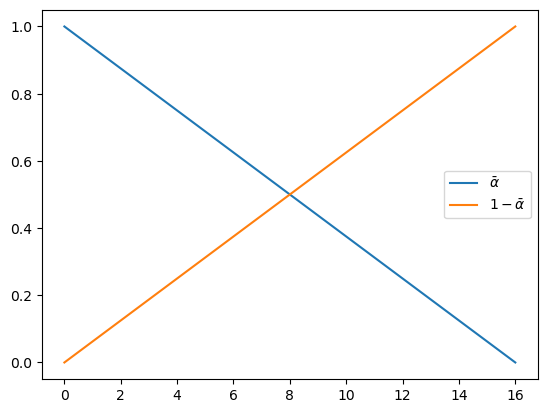

In [106]:
plt.plot(time_bar, label=r'$\bar{\alpha}$')
plt.plot(1 - time_bar, label=r'$1-\bar{\alpha}$')
plt.legend();

## Dataset

In [4]:
# Prepare CIFAR10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

all_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# filter training imgs
idx = [i for i, (img, label) in enumerate(all_trainset) if label == 1]
sub_trainset = torch.utils.data.Subset(all_trainset, idx)

trainloader = torch.utils.data.DataLoader(sub_trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


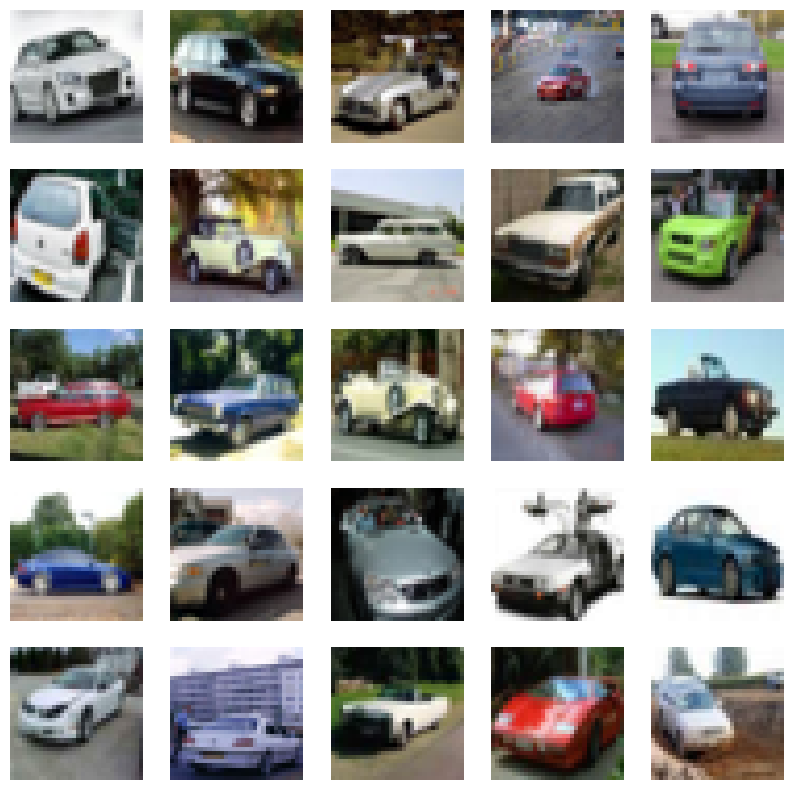

In [50]:
def cvtImg(img):
    img = img.permute([0, 2, 3, 1])
    img = img - img.min()
    img = (img / img.max())
    return img.numpy().astype(np.float32)

def show_examples(x):
    plt.figure(figsize=(10, 10))
    #imgs = cvtImg(x)
    for i in range(25):
        img = cvtImg(x[i].unsqueeze(0))
        plt.subplot(5, 5, i+1)
        #plt.imshow(imgs[i])
        plt.imshow(img[0])
        plt.axis('off')

x, _ = next(iter(trainloader))
show_examples(x)

## Forward Diffusion Model

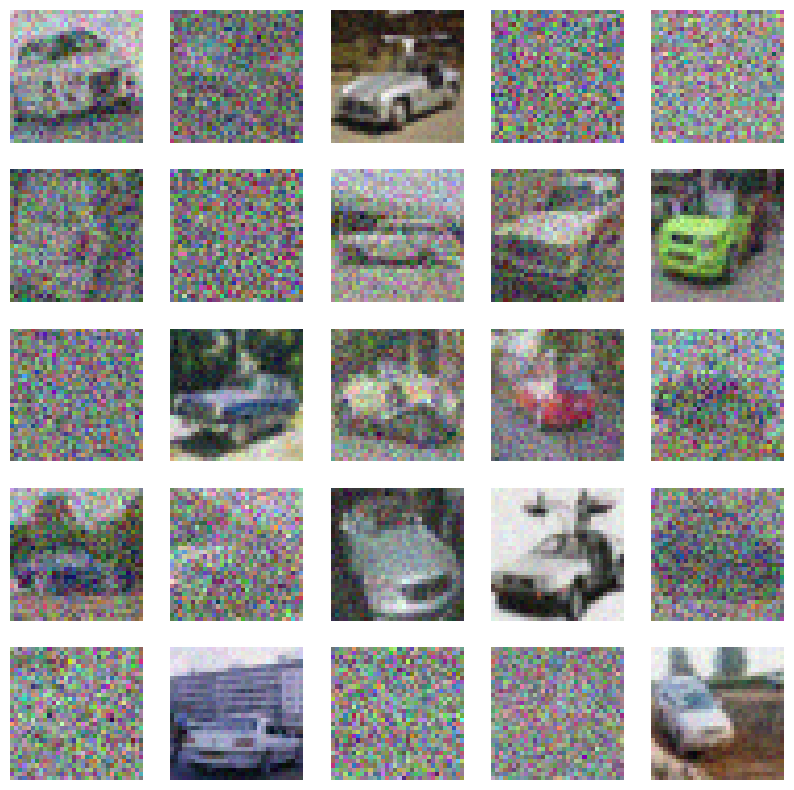

In [51]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
#x, _ = next(iter(trainloader))
a, b = forward_noise(x[:25], t)
show_examples(a)

## Neural Network

In [53]:
class Block(nn.Module):
    def __init__(self, in_channels=128, size=32):
        super(Block, self).__init__()
        
        self.conv_param = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)
        self.conv_out = nn.Conv2d(in_channels=in_channels, out_channels=128, kernel_size=3, padding=1)

        self.dense_ts = nn.Linear(192, 128)

        self.layer_norm = nn.LayerNorm([128, size, size])

    def forward(self, x_img, x_ts):
        x_parameter = F.relu(self.conv_param(x_img))

        time_parameter = F.relu(self.dense_ts(x_ts))
        time_parameter = time_parameter.view(-1, 128, 1, 1)
        x_parameter = x_parameter * time_parameter

        x_out = self.conv_out(x_img)
        x_out = x_out + x_parameter
        x_out = F.relu(self.layer_norm(x_out))

        return x_out

In [108]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.l_ts = nn.Sequential(
            nn.Linear(1, 192),
            nn.LayerNorm([192]),
            nn.ReLU(),
        )
        
        self.down_x32 = Block(in_channels=3, size=32)
        self.down_x16 = Block(size=16)
        self.down_x8 = Block(size=8)
        self.down_x4 = Block(size=4)
        
        self.mlp = nn.Sequential(
            nn.Linear(2240, 128),
            nn.LayerNorm([128]),
            nn.ReLU(),
            
            nn.Linear(128, 32 * 4 * 4), # make [-1, 32, 4, 4]
            nn.LayerNorm([32 * 4 * 4]),
            nn.ReLU(),
        )
        
        self.up_x4 = Block(in_channels=32 + 128, size=4)
        self.up_x8 = Block(in_channels=256, size=8)
        self.up_x16 = Block(in_channels=256, size=16)
        self.up_x32 = Block(in_channels=256, size=32)
        
        self.cnn_output = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, padding=0)
        
        # make optimizer
        self.opt = torch.optim.Adam(self.parameters(), lr=0.0008)
    
    def forward(self, x, x_ts):
        x_ts = self.l_ts(x_ts)
        
        # ----- left ( down ) -----
        blocks = [
            self.down_x32,
            self.down_x16,
            self.down_x8,
            self.down_x4,
        ]
        x_left_layers = []
        for i, block in enumerate(blocks):
            x = block(x, x_ts)
            x_left_layers.append(x)
            if i < len(blocks) - 1:
                x = F.max_pool2d(x, 2)
                
        # ----- MLP -----
        x = x.view(-1, 128 * 4 * 4)
        x = torch.cat([x, x_ts], dim=1)
        x = self.mlp(x)
        x = x.view(-1, 32, 4, 4)
        
        # ----- right ( up ) -----
        blocks = [
            self.up_x4,
            self.up_x8,
            self.up_x16,
            self.up_x32,
        ]
        
        for i, block in enumerate(blocks):
            # cat left
            x_left = x_left_layers[len(blocks) - i - 1]
            x = torch.cat([x, x_left], dim=1)
            
            x = block(x, x_ts)
            if i < len(blocks) - 1:
                x = F.interpolate(x, scale_factor=2, mode='bilinear')
                
        # ----- output -----
        x = self.cnn_output(x)

        return x

model = Model().to(device)

## Before Training

100%|██████████| 16/16 [00:00<00:00, 170.49it/s]


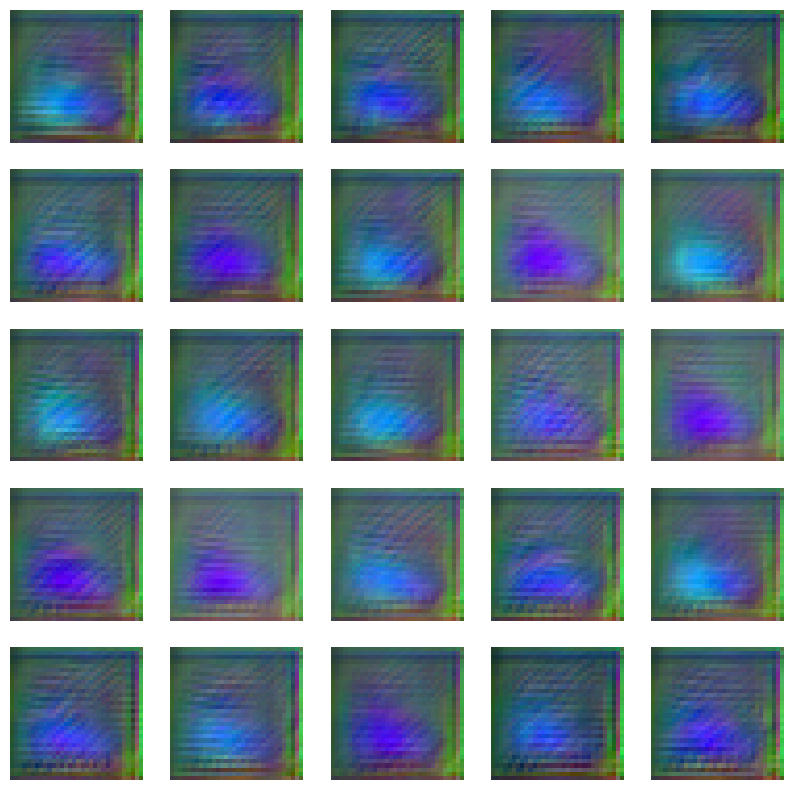

In [109]:
def predict(x_idx=None):
    x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE).to(device)
    with torch.no_grad():
        for i in tqdm(range(timesteps)):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))

    show_examples(x.cpu())

predict()

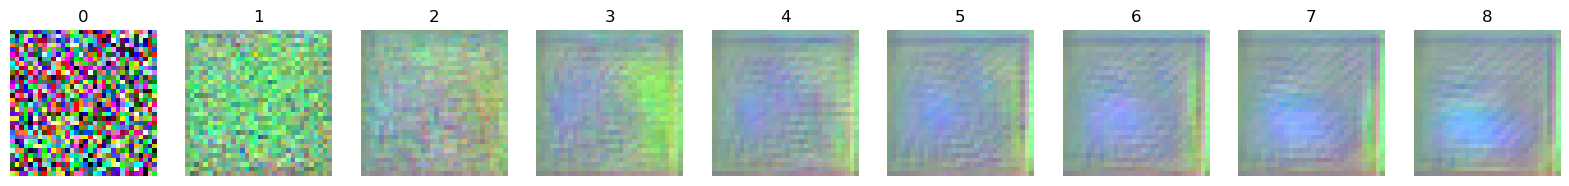

In [110]:
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)
    xs.append(x[0].cpu())

    with torch.no_grad():
        for i in range(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

## Training

In [58]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    
    x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
    x_a = x_a.float().to(device)
    x_b = x_b.float().to(device)
    
    y_p = model(x_a, x_ts)
    loss = torch.mean(torch.abs(y_p - x_b))
    model.opt.zero_grad()
    loss.backward()
    model.opt.step()
    
    return loss.item()

In [59]:
def train(R=50):
    bar = range(R)
    total = len(trainloader)
    for i in tqdm(bar):
        for j, (x_img, _) in enumerate(trainloader):
            loss = train_one(x_img)

In [60]:
model.to(device)

Model(
  (l_ts): Sequential(
    (0): Linear(in_features=1, out_features=192, bias=True)
    (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (down_x32): Block(
    (conv_param): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=192, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
  )
  (down_x16): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=192, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (down_x8): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_

100%|██████████| 50/50 [04:21<00:00,  5.22s/it]


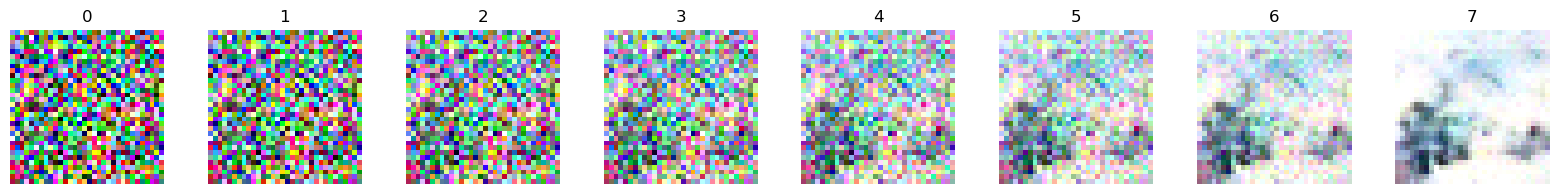

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


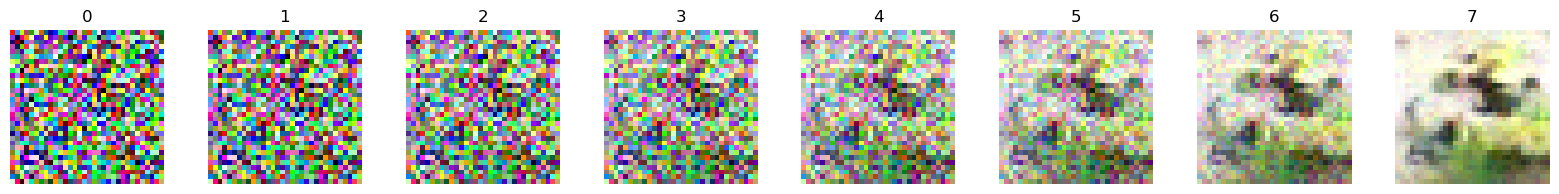

100%|██████████| 50/50 [04:21<00:00,  5.23s/it]


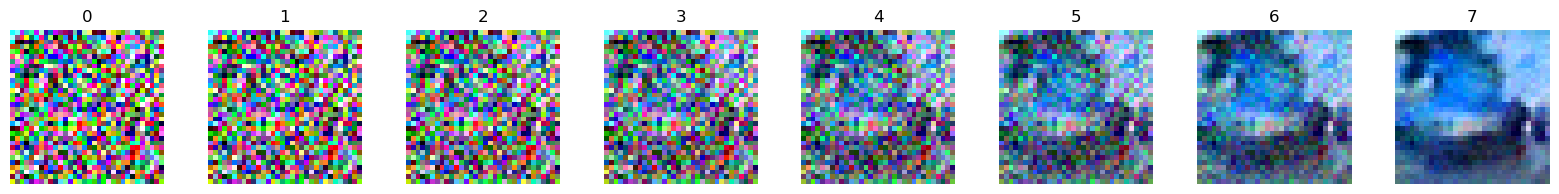

100%|██████████| 50/50 [04:22<00:00,  5.24s/it]


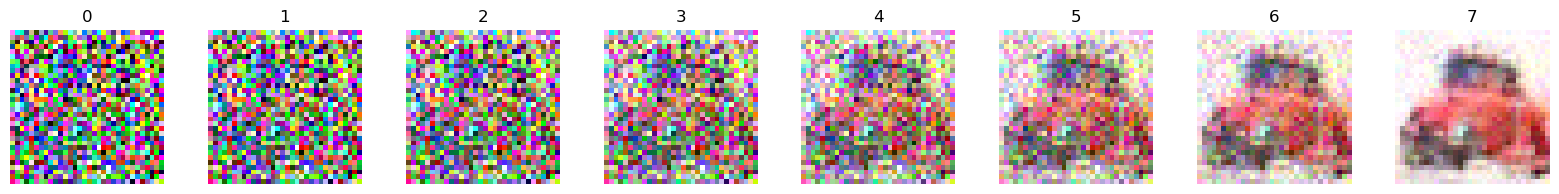

100%|██████████| 50/50 [04:23<00:00,  5.26s/it]


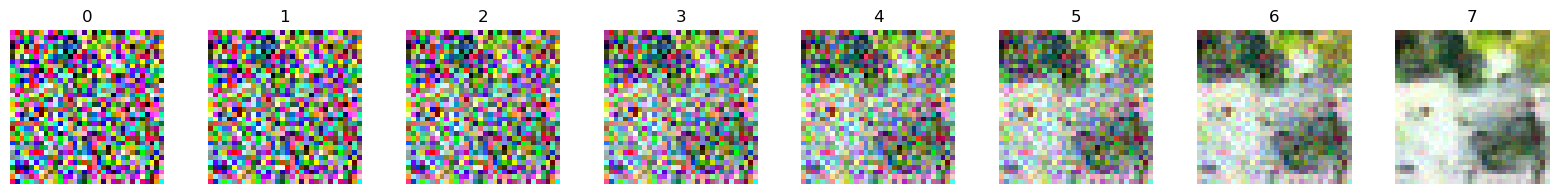

100%|██████████| 50/50 [04:24<00:00,  5.28s/it]


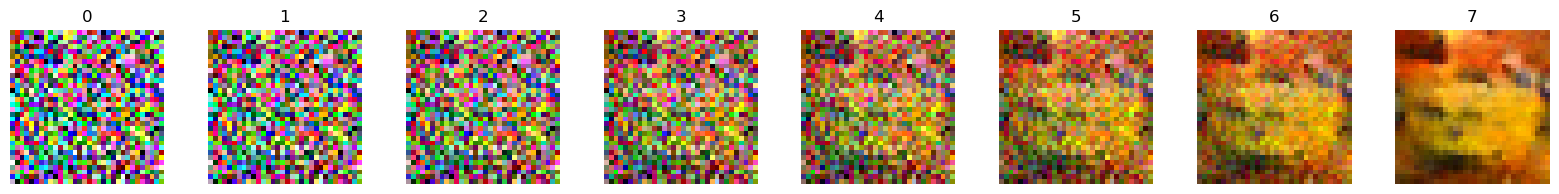

100%|██████████| 50/50 [04:20<00:00,  5.20s/it]


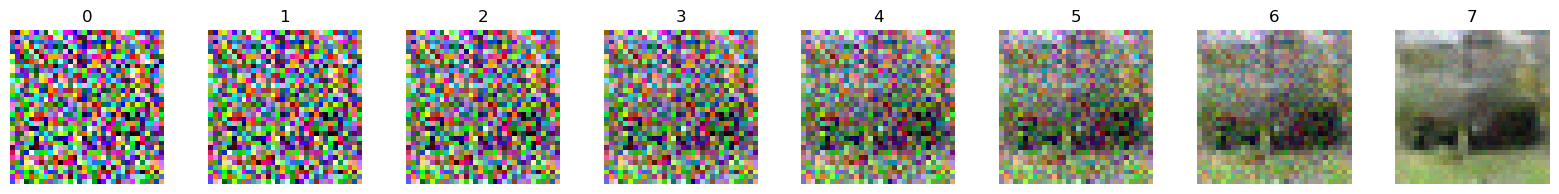

100%|██████████| 50/50 [04:23<00:00,  5.28s/it]


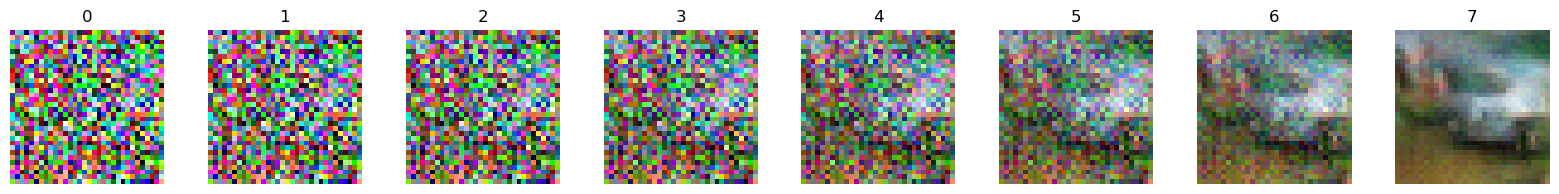

100%|██████████| 50/50 [04:23<00:00,  5.28s/it]


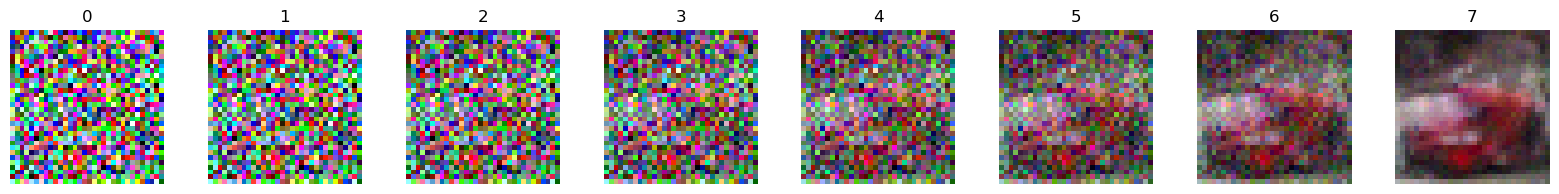

100%|██████████| 50/50 [04:22<00:00,  5.25s/it]


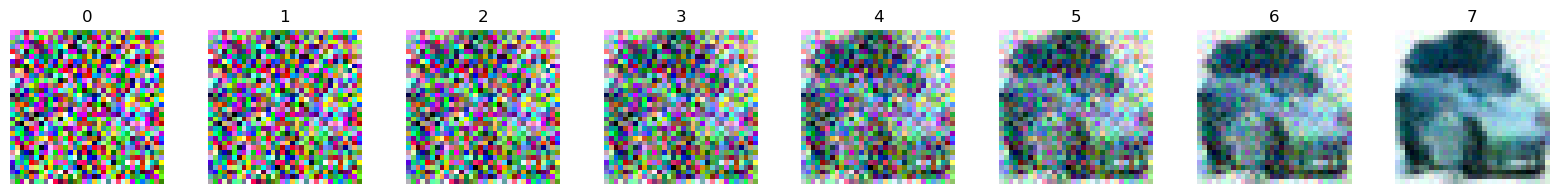

100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


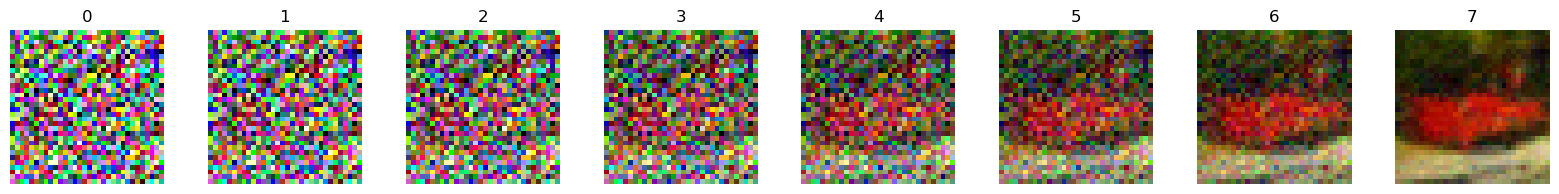

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


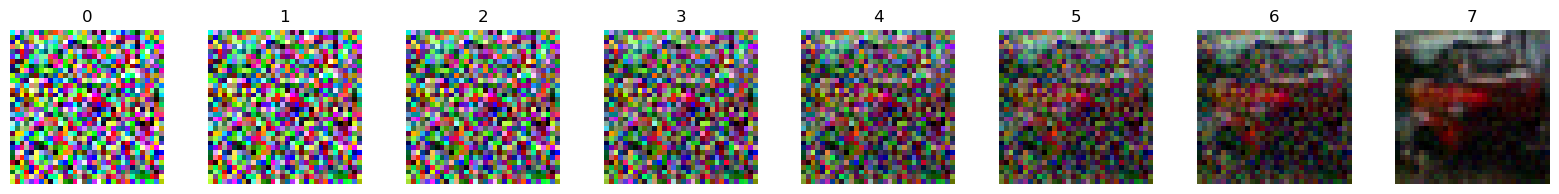

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


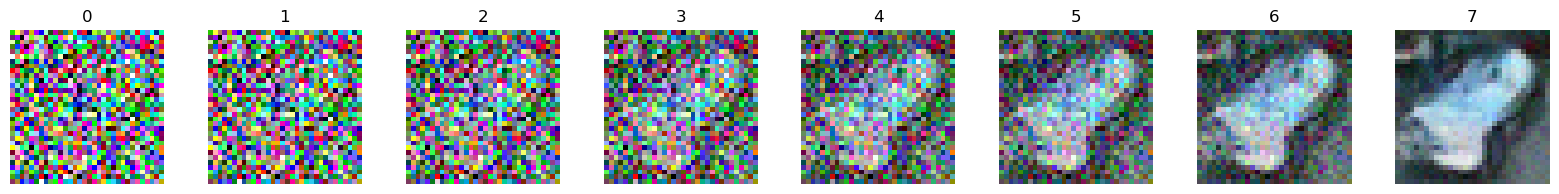

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


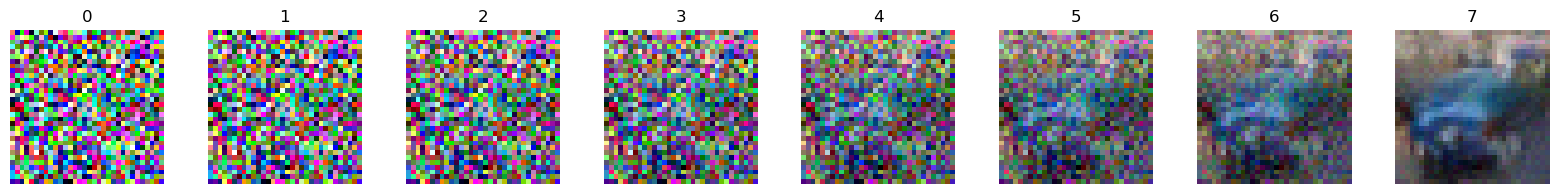

100%|██████████| 50/50 [04:23<00:00,  5.26s/it]


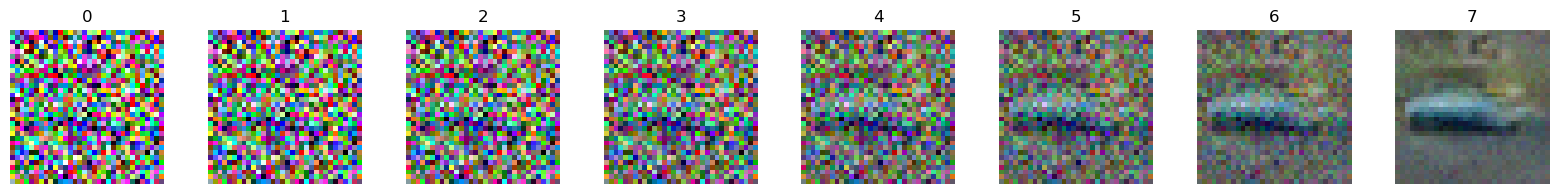

100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


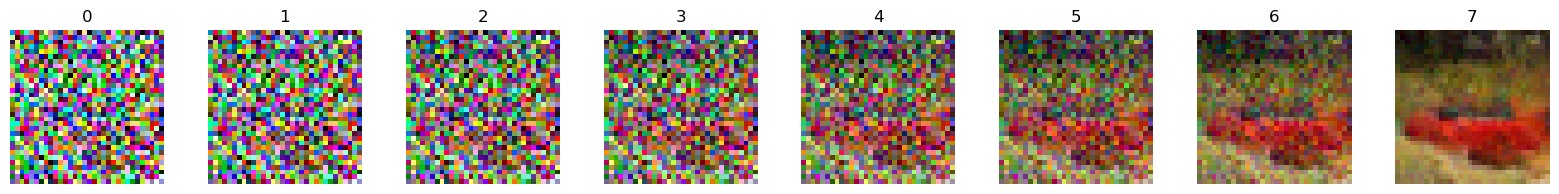

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


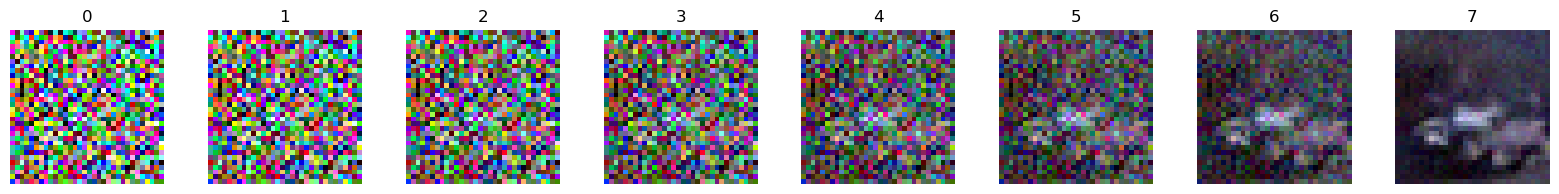

100%|██████████| 50/50 [04:23<00:00,  5.28s/it]


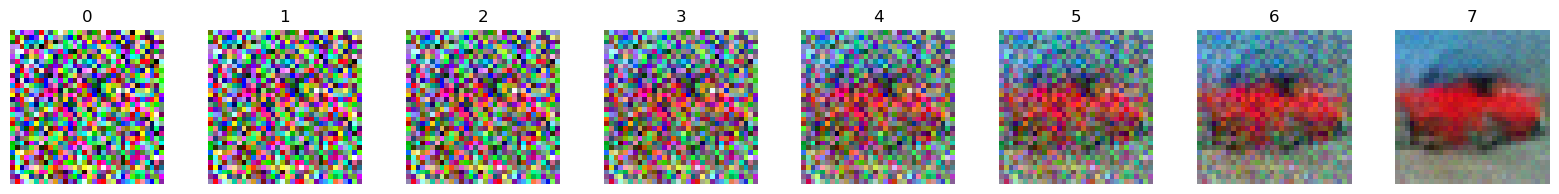

100%|██████████| 50/50 [04:22<00:00,  5.24s/it]


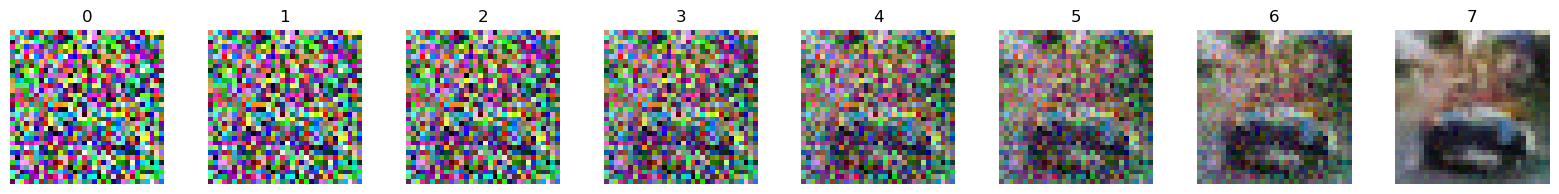

100%|██████████| 50/50 [04:22<00:00,  5.25s/it]


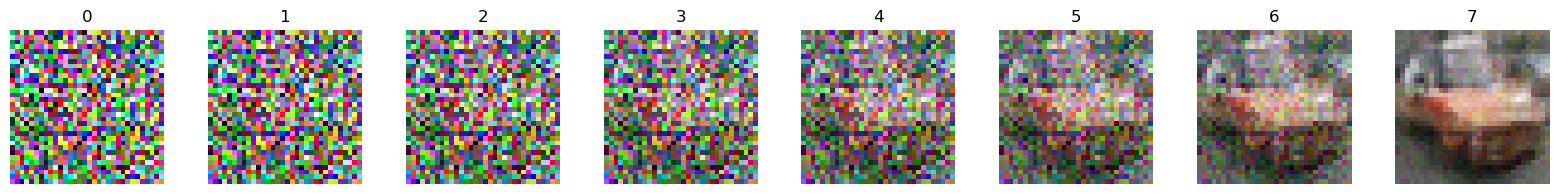

100%|██████████| 50/50 [04:23<00:00,  5.26s/it]


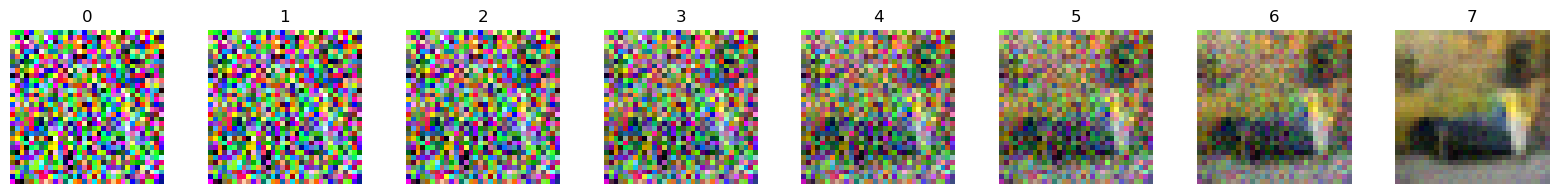

100%|██████████| 50/50 [04:23<00:00,  5.26s/it]


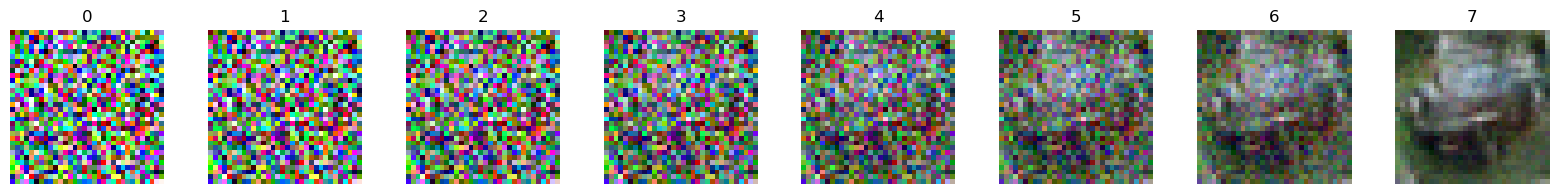

100%|██████████| 50/50 [04:20<00:00,  5.22s/it]


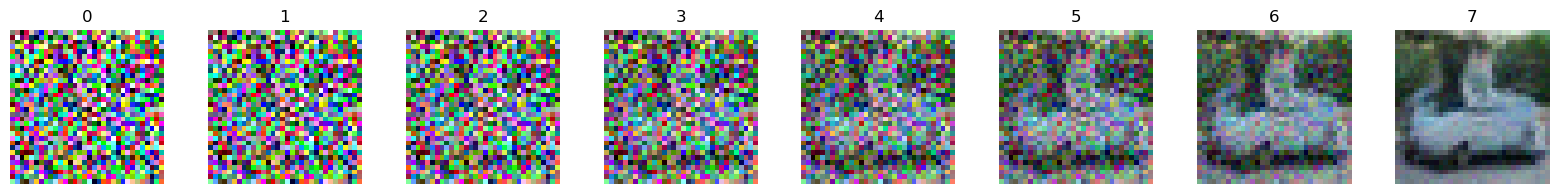

100%|██████████| 50/50 [04:22<00:00,  5.25s/it]


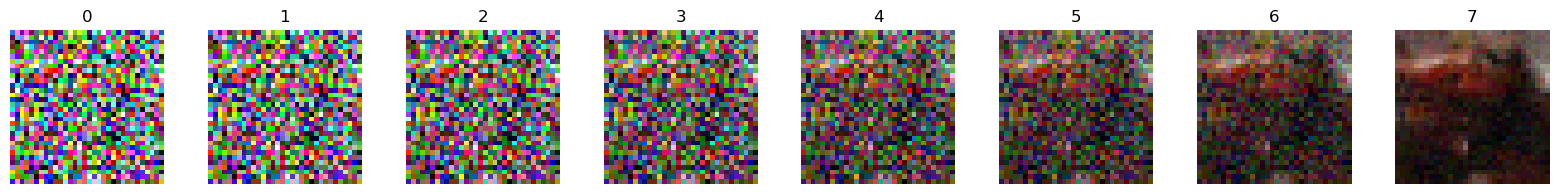

100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


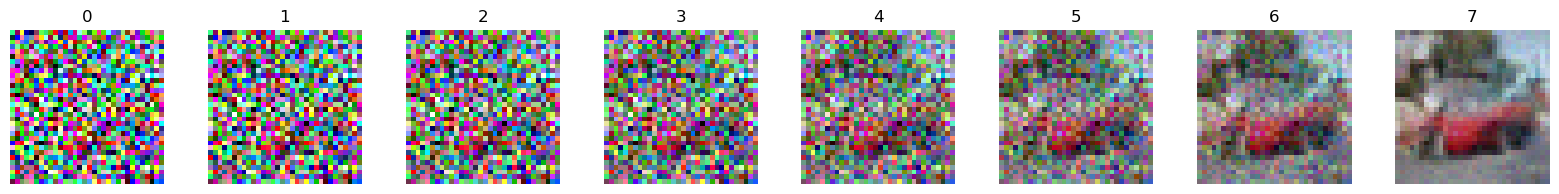

100%|██████████| 50/50 [04:21<00:00,  5.24s/it]


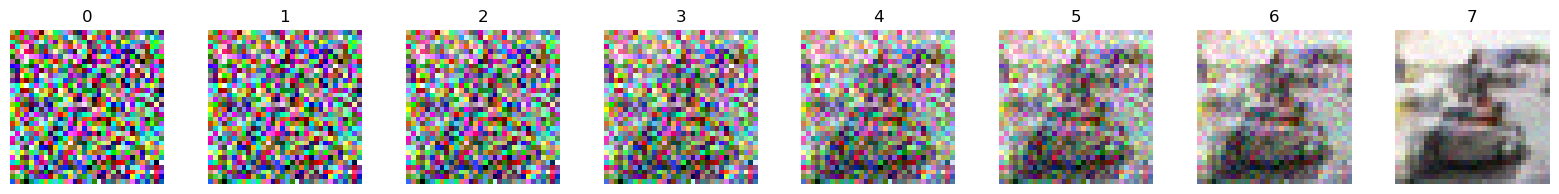

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


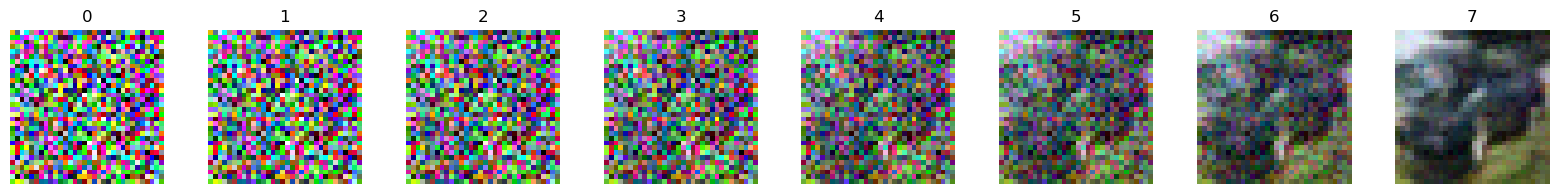

100%|██████████| 50/50 [04:24<00:00,  5.29s/it]


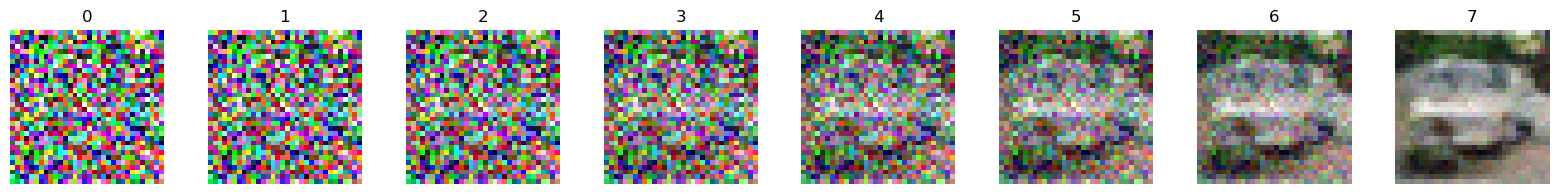

100%|██████████| 50/50 [04:23<00:00,  5.28s/it]


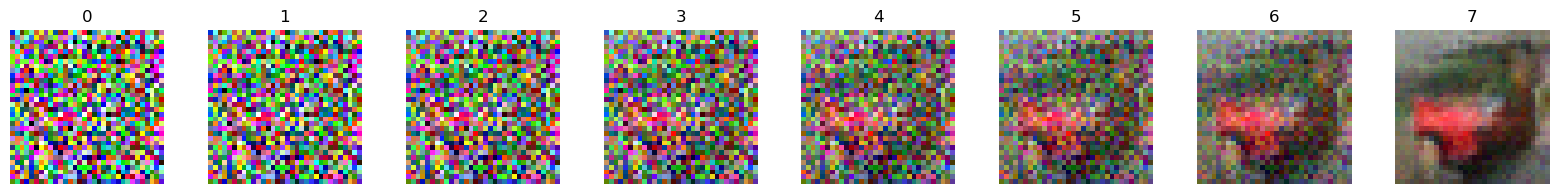

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


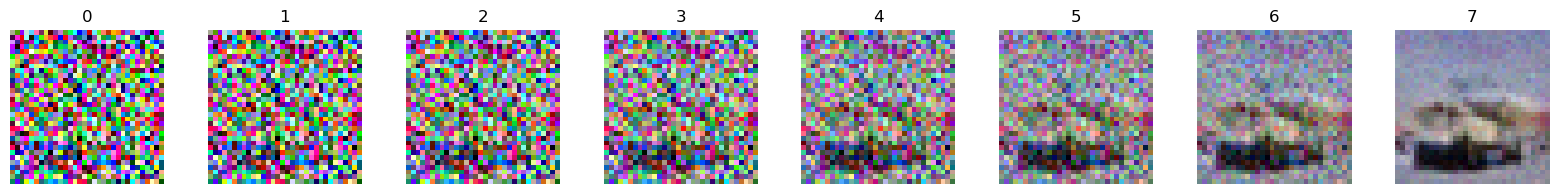

100%|██████████| 50/50 [04:22<00:00,  5.25s/it]


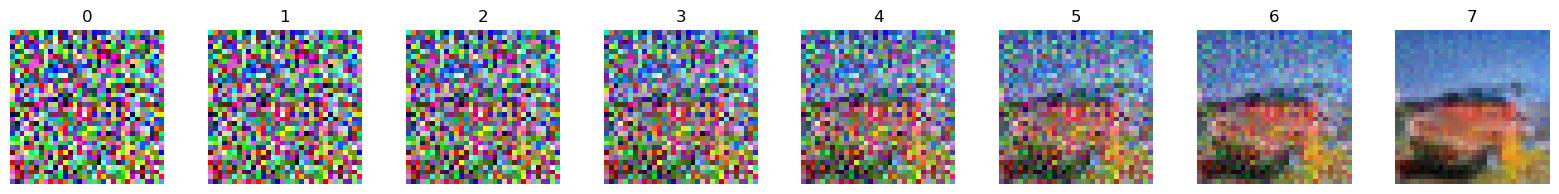

100%|██████████| 50/50 [04:23<00:00,  5.28s/it]


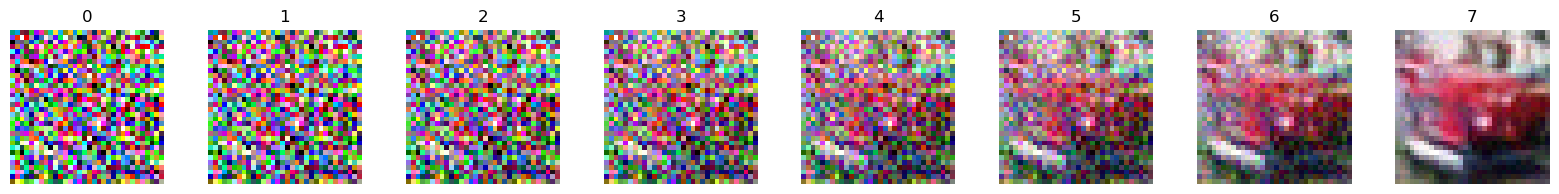

100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


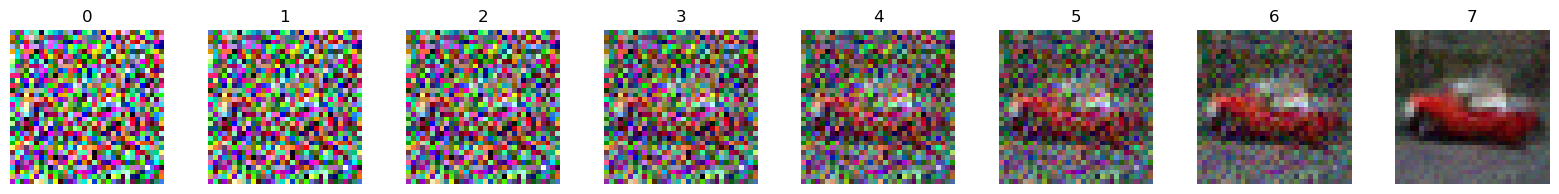

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


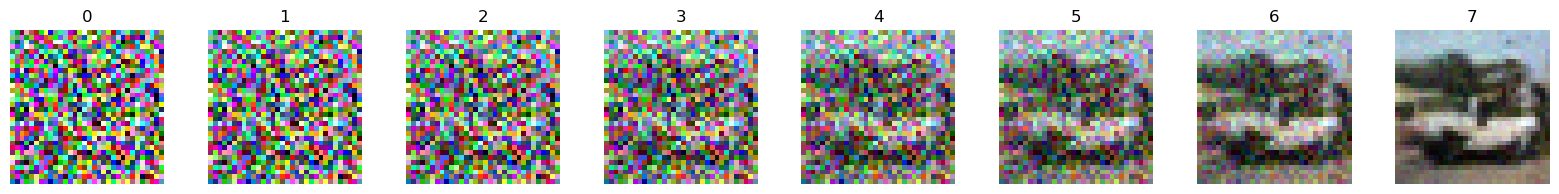

100%|██████████| 50/50 [04:23<00:00,  5.28s/it]


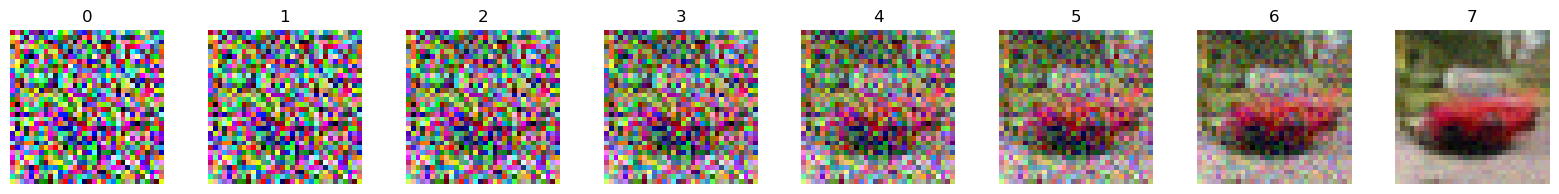

100%|██████████| 50/50 [04:24<00:00,  5.29s/it]


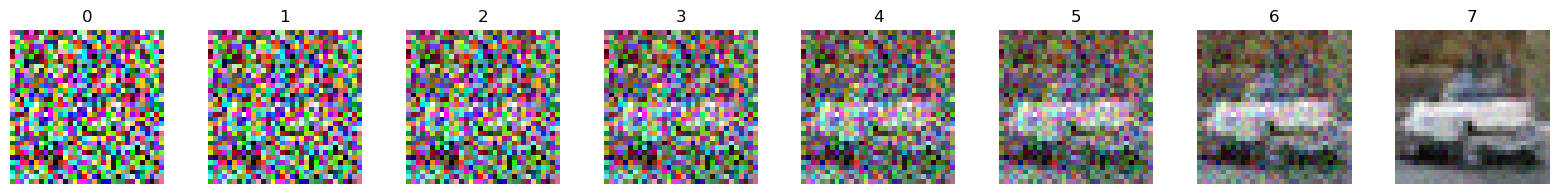

100%|██████████| 50/50 [04:21<00:00,  5.23s/it]


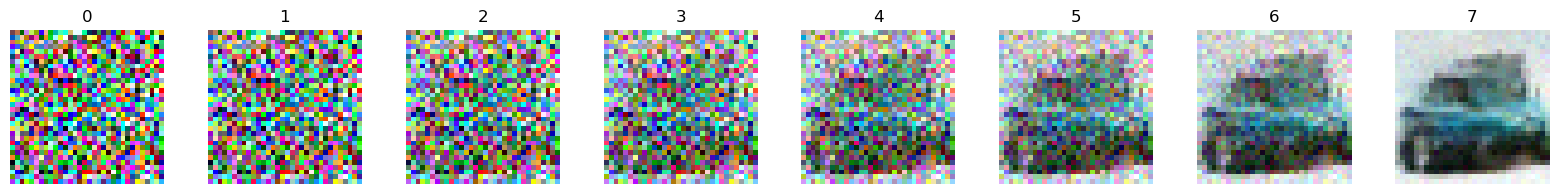

100%|██████████| 50/50 [04:22<00:00,  5.25s/it]


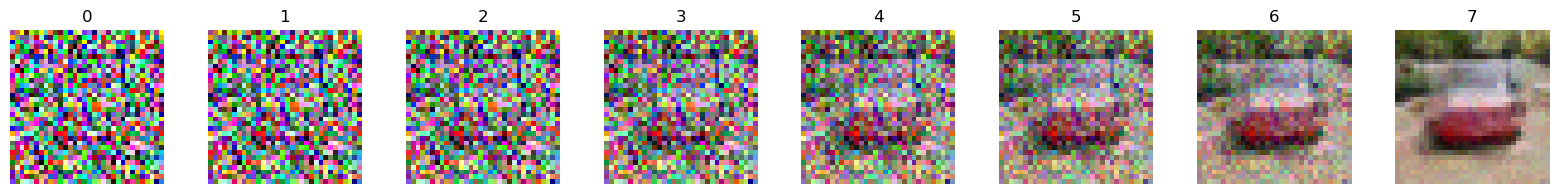

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


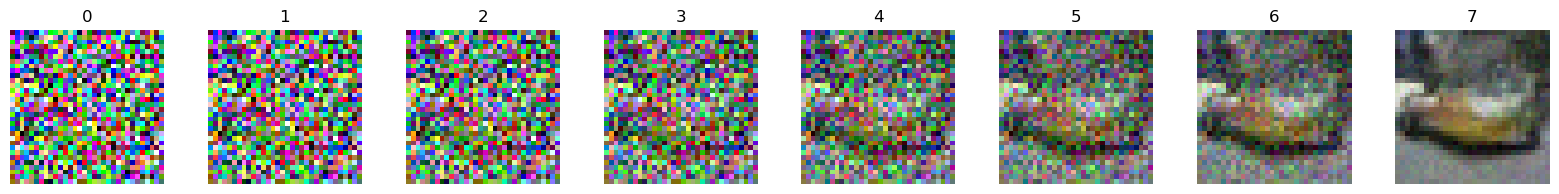

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


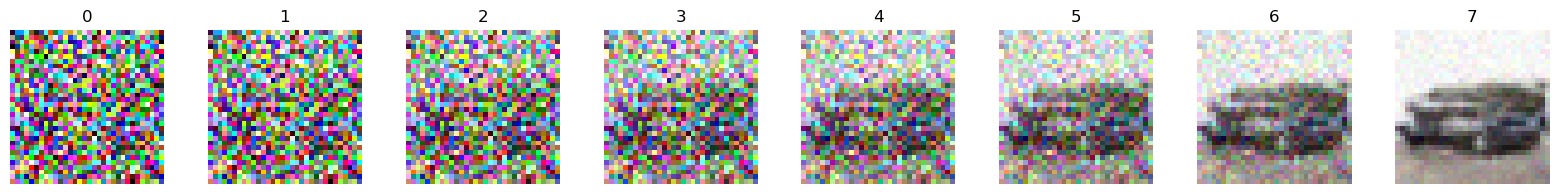

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


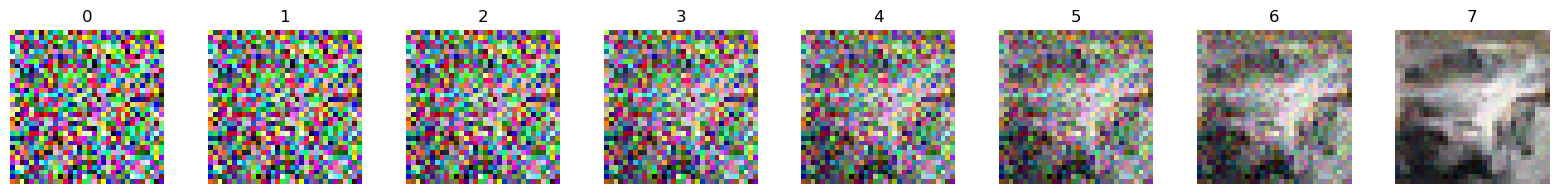

100%|██████████| 50/50 [04:22<00:00,  5.24s/it]


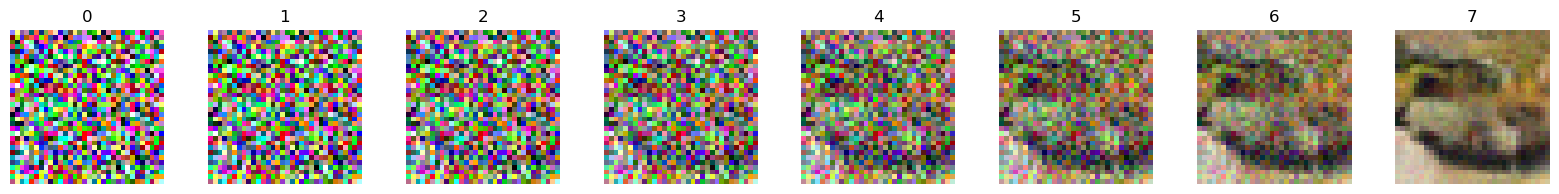

100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


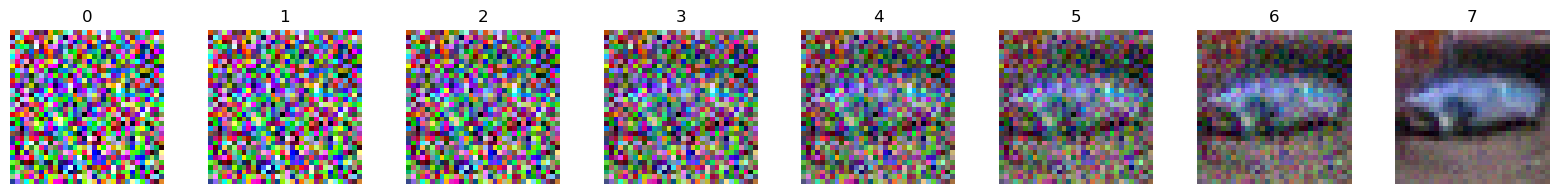

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


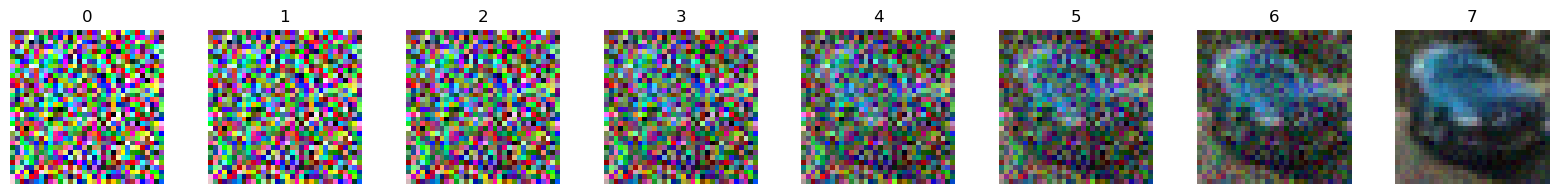

100%|██████████| 50/50 [04:24<00:00,  5.28s/it]


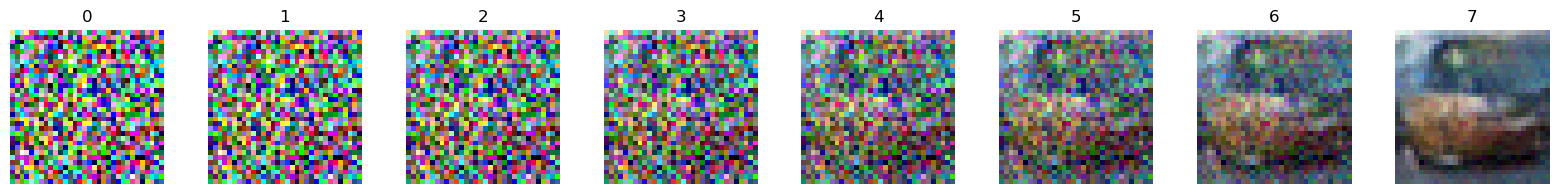

100%|██████████| 50/50 [04:24<00:00,  5.28s/it]


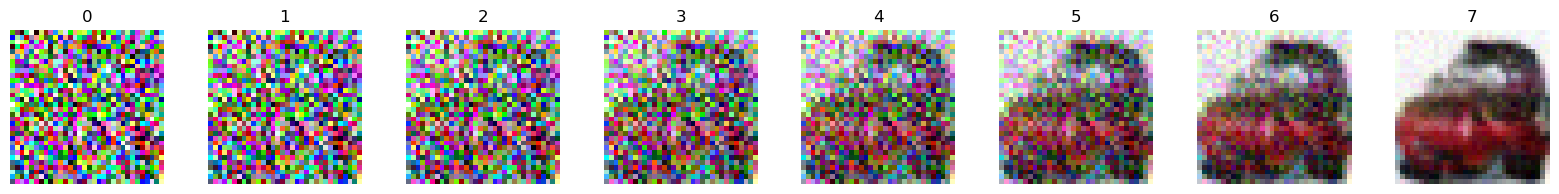

100%|██████████| 50/50 [04:24<00:00,  5.29s/it]


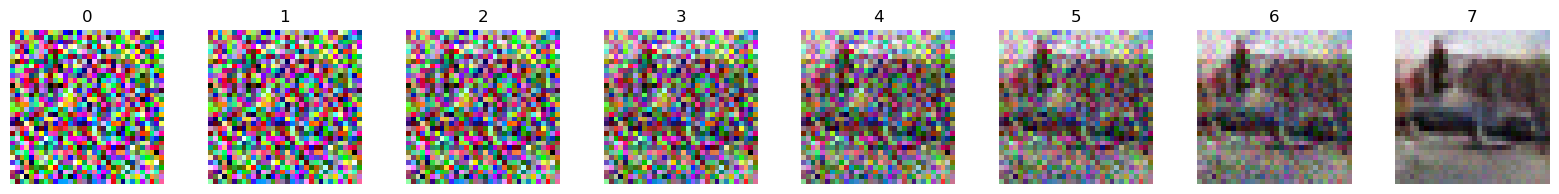

100%|██████████| 50/50 [04:23<00:00,  5.27s/it]


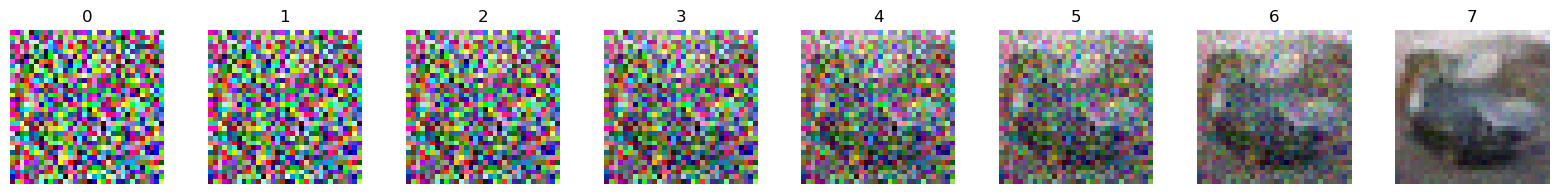

100%|██████████| 50/50 [04:23<00:00,  5.26s/it]


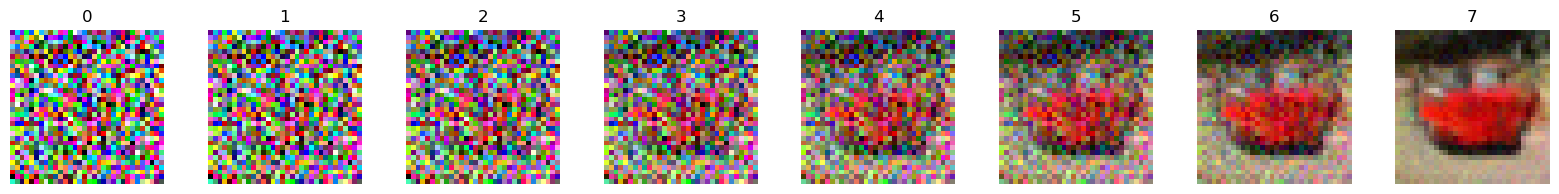

100%|██████████| 50/50 [04:22<00:00,  5.26s/it]


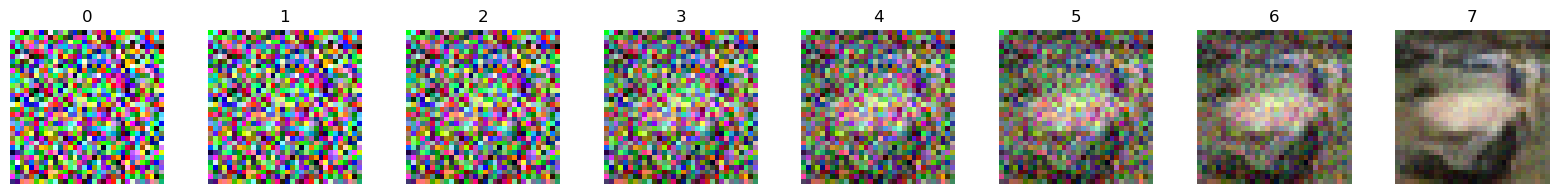

In [62]:
for _ in range(50):
    train()
    # reduce learning rate for next training
    for pg in model.opt.param_groups:
        pg['lr'] = max(0.000001, pg['lr'] * 0.9)

    # show result 
    #predict()
    predict_step()
    plt.show()

## After Training

100%|██████████| 16/16 [00:00<00:00, 186.42it/s]


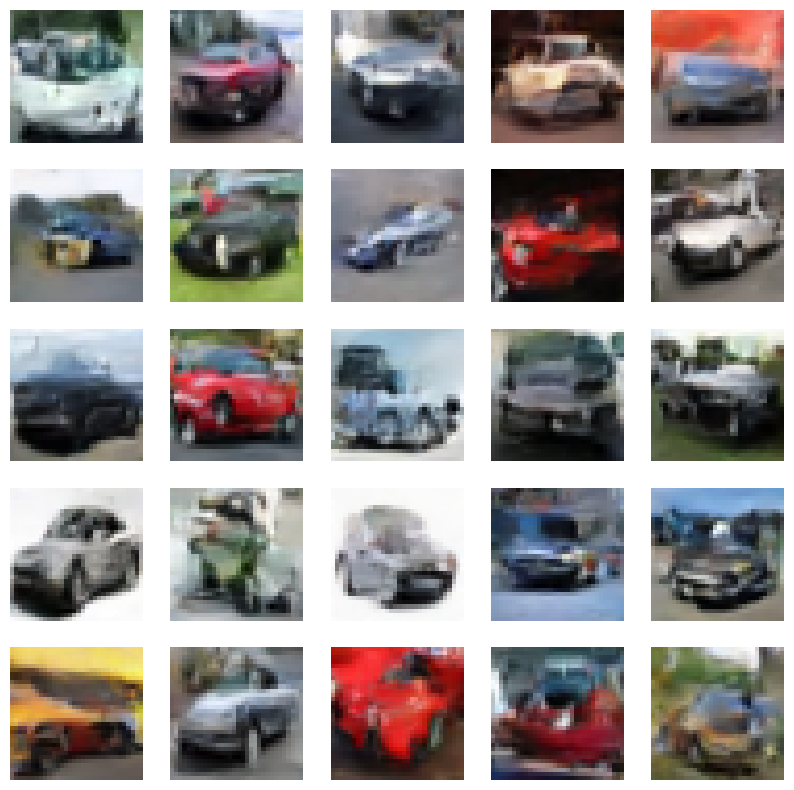

In [68]:
predict()

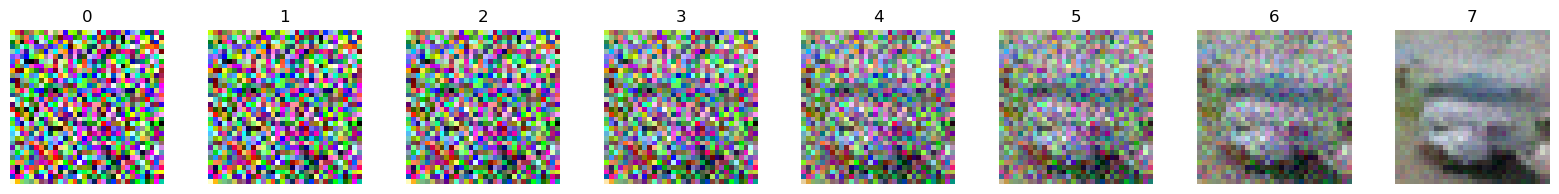

In [69]:
predict_step()

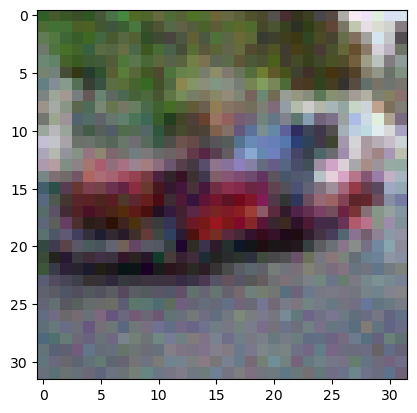

In [100]:
# Animated GIF for demonstration purposes

fig, ax = plt.subplots()
im = ax.imshow(xs[0])

# Function to update the frame
def update(frame):
    im.set_array(xs[min(timesteps-1,frame)])
    return line,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=timesteps+10, interval=1, blit=True)

# Save the animation as a video (e.g., MP4)
ani.save("generate.gif", writer="pillow", fps=5)

plt.show()

## Save and/or Load Model

In [64]:
# Uncomment the following line if you want to save your network.
#torch.save(model.to('cpu'), 'diff_model_50epochs.pt')

In [66]:
# The corresponding code to reload the network is below.
model = torch.load('diff_model_50epochs.pt')
# Remember to send it to the GPU, if you're using one.
model.to(device)

/tmp/ipykernel_122090/1603509342.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('diff_model_50epochs.pt')


Model(
  (l_ts): Sequential(
    (0): Linear(in_features=1, out_features=192, bias=True)
    (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (down_x32): Block(
    (conv_param): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=192, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 32, 32), eps=1e-05, elementwise_affine=True)
  )
  (down_x16): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dense_ts): Linear(in_features=192, out_features=128, bias=True)
    (layer_norm): LayerNorm((128, 16, 16), eps=1e-05, elementwise_affine=True)
  )
  (down_x8): Block(
    (conv_param): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_out): Conv2d(128, 128, kernel_